# CountMatch Matcher Development
## Part 1: Prototype

This notebook is a testbed for developing CountMatch's matcher.  The end result is a functionalized prototype of all PRTCS functionality after determining growth rates and finding nearest neighbours.

In [102]:
%matplotlib inline
import sys
sys.path.append('../')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import growthfactor as gf
from traffic_prophet.countmatch import neighbour

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['key']

In [2]:
rdr = reader.Reader(vol_conn)
%time rdr.read()

CPU times: user 1min 34s, sys: 1.58 s, total: 1min 36s
Wall time: 1min 46s


In [3]:
gf.get_growth_factors(rdr)

In [4]:
ptc_ids = np.unique(np.abs(list(rdr.ptcs.keys())))
nb = neighbour.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
%time nb.find_neighbours()

CPU times: user 18.7 s, sys: 609 ms, total: 19.3 s
Wall time: 19 s


## Growth Factor Diagnostic

In [5]:
growth_factors = pd.DataFrame([(x.count_id, x.growth_factor) for x in rdr.ptcs.values()])
growth_factors.columns = ['count_id', 'growth_factor']
growth_factors['n_years'] = [x.data['AADT'].shape[0] for x in rdr.ptcs.values()]

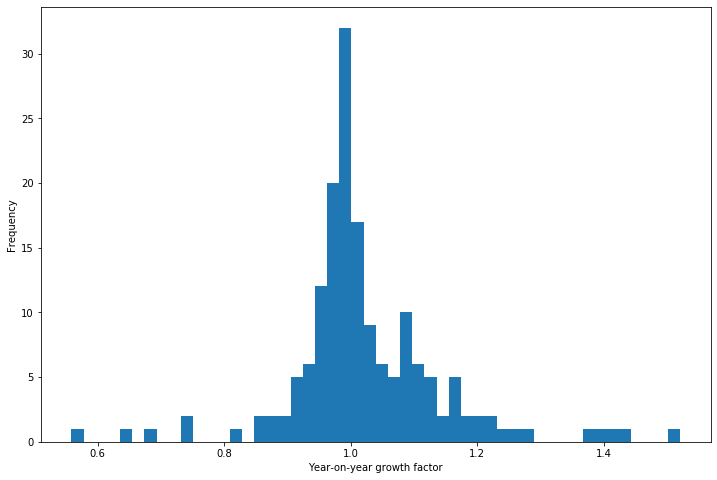

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
growth_factors['growth_factor'].plot(kind='hist', bins=50, ax=ax)
ax.set_xlabel("Year-on-year growth factor");

In [7]:
growth_factors['deviation'] = np.abs(growth_factors['growth_factor'].values - 1.)

In [8]:
growth_factors.sort_values('deviation', ascending=False).head(20)

,count_id,growth_factor,n_years,deviation
46,-1147347,1.520300,1,0.520300
76,-13515818,0.558741,1,0.441259
93,30021327,1.434079,1,0.434079
74,-12763897,1.408812,1,0.408812
91,30018111,1.390293,1,0.390293
62,8492502,1.369492,1,0.369492
94,-30021784,0.649801,1,0.350199
159,14255077,0.674891,2,0.325109
133,444516,1.271847,1,0.271847
153,-8491741,1.266449,1,0.266449


In [9]:
rdr.ptcs[-1147347].data['MADT']

MADT  Days in Month
Year Month                             
2010 1      20973.160000             31
     2      21944.120000             28
     3      24969.807692             31
     4      26666.800000             30
     5      30188.275862             31
     6      35044.925926             30
     7      30685.133333             31
     8      37634.666667             31
     9      37831.653846             30
     10     38327.920000             31
     11     32268.222222             30
     12     29878.958333             31

In [10]:
rdr.ptcs[20044187].data['MADT']

MADT  Days in Month
Year Month                             
2016 1      18614.933333             31
     2      19559.275862             29
     3      19500.904762             31
     4      20853.937500             30
     5      21523.250000             31
     6      20992.766667             30
     7      20290.962963             31
     8      21129.500000             31
     9      20861.866667             30
     10     20003.807692             31
     11     20649.714286             30
     12     19154.000000             31
2017 1      18021.833333             31
     2      19777.166667             28
     3      19881.280000             31
     4      18491.136364             30
     5      13680.346154             31
     6      14582.960000             30
     7      13278.357143             31
     8      13494.884615             31
     9      12236.000000             30
     10     12274.444444             31
     11     13062.280000             30
     12     10549.448276             31

In [11]:
rdr.ptcs[20044187].data['Daily Count'].loc[(2016, 130):(2016, 160), :]

Date  Daily Count
Year Day of Year                        
2016 131         2016-05-10      22255.0
     132         2016-05-11      23108.0
     133         2016-05-12      22894.0
     134         2016-05-13      20479.0
     136         2016-05-15      26467.0
     137         2016-05-16      20634.0
     138         2016-05-17      21006.0
     139         2016-05-18      22323.0
     140         2016-05-19      22568.0
     141         2016-05-20      21954.0
     142         2016-05-21      19376.0
     143         2016-05-22      17192.0
     144         2016-05-23      18228.0
     145         2016-05-24      20756.0
     146         2016-05-25      21964.0
     147         2016-05-26      22339.0
     153         2016-06-01      21574.0
     154         2016-06-02      21499.0
     155         2016-06-03      22352.0
     156         2016-06-04      21248.0
     157         2016-06-05      20843.0
     158         2016-06-06      19221.0
     159         2016-06-07      20457.0
     160         2016-06-08      21076.0

In [12]:
rdr.ptcs[20044187].data['Daily Count'].loc[(2017, 130):(2017, 160), :]

Date  Daily Count
Year Day of Year                        
2017 130         2017-05-10      13946.0
     131         2017-05-11      14093.0
     132         2017-05-12      15232.0
     133         2017-05-13      14109.0
     134         2017-05-14      12924.0
     136         2017-05-16      14044.0
     139         2017-05-19       9076.0
     140         2017-05-20       4773.0
     141         2017-05-21       7395.0
     142         2017-05-22       9939.0
     143         2017-05-23      12483.0
     144         2017-05-24      12374.0
     145         2017-05-25      14425.0
     146         2017-05-26      14235.0
     147         2017-05-27      15776.0
     148         2017-05-28      13662.0
     149         2017-05-29      12210.0
     150         2017-05-30      14151.0
     153         2017-06-02      17092.0
     154         2017-06-03      14559.0
     155         2017-06-04      17453.0
     156         2017-06-05      13423.0
     157         2017-06-06      14131.0
     158         2017-06-07      15592.0
     159         2017-06-08      13446.0
     160         2017-06-09      14563.0

## How Close are PTCs?

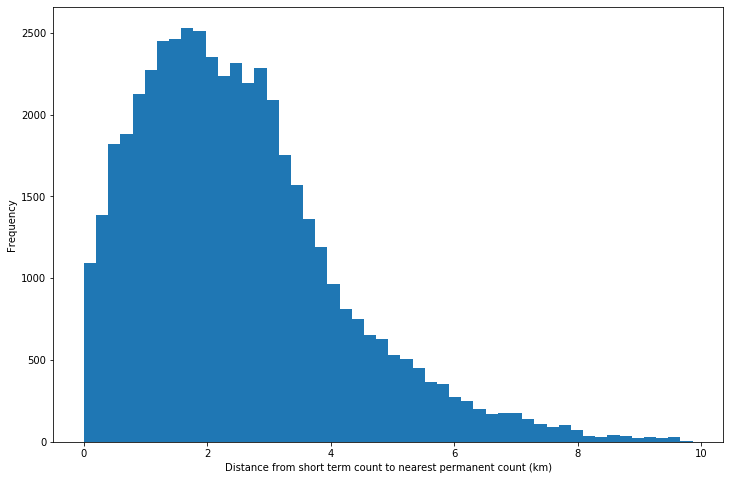

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
nb.data['Distances'].apply(lambda x: x[0]).plot(kind='hist', bins=50, ax=ax)
ax.set_xlabel("Distance from short term count to nearest permanent count (km)");

In [14]:
kyd.kyd(nb.data['Distances'].apply(lambda x: x[0]));

| Basic Statistics                                          | Array Structure                	|
|                                                           |                                	|
|    Mean:         Min:   0.004628    -99 CI:   0.05759     | Number of Dimensions:   1      	|
|    2.521          1Q:   1.303       -95 CI:   0.2169      | Shape of Dimensions:    (47908,)	|
|               Median:   2.268       -68 CI:   0.9328      | Array Data Type:        float64	|
|   Std Dev:        3Q:   3.375       +68 CI:   4.014       | Memory Size:            374.4KiB	|
|    1.637         Max:   9.862       +95 CI:   6.609       |                                	|
|                                     +99 CI:   8.122       | Number of NaN:  0              	|
|                                                           | Number of Inf:  0              	|

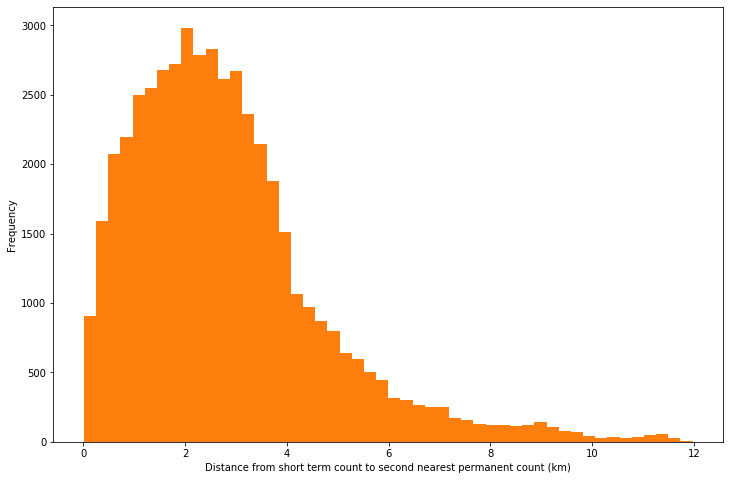

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
nb.data['Distances'].apply(lambda x: x[1]).plot(kind='hist', bins=50, ax=ax, color=defaultcolours[1])
ax.set_xlabel("Distance from short term count to second nearest permanent count (km)");

In [16]:
kyd.kyd(nb.data['Distances'].apply(lambda x: x[1]));

| Basic Statistics                                          | Array Structure                	|
|                                                           |                                	|
|    Mean:         Min:   0.007617    -99 CI:   0.1081      | Number of Dimensions:   1      	|
|    2.799          1Q:   1.459       -95 CI:   0.3018      | Shape of Dimensions:    (47908,)	|
|               Median:   2.482       -68 CI:   1.052       | Array Data Type:        float64	|
|   Std Dev:        3Q:   3.636       +68 CI:   4.359       | Memory Size:            374.4KiB	|
|    1.883         Max:   11.98       +95 CI:   7.877       |                                	|
|                                     +99 CI:   10.28       | Number of NaN:  0              	|
|                                                           | Number of Inf:  0              	|

## Playground

### NaN imputation

In [17]:
rdr.ptcs.keys()

dict_keys([8540609, -890, 1003, 1821, -104870, 105654, -440789, -440946, 440946, -442161, 442292, -442447, 443965, -443975, -443987, -444637, 444782, 445280, -445309, 1144030, -1144036, -1145202, 1145202, 1145376, -1145405, -1145667, 1145768, 1146181, 1146200, -1146202, -1146335, -1146358, 1146445, -1146615, 1146843, -1146997, 1147010, 1147078, -1147113, 1147127, -1147184, 1147194, -1147201, 1147201, -1147234, -1147316, -1147347, 1147347, -1147434, 1147464, 1147466, 1147489, 1147544, 1147551, 2370044, 5439765, 5866210, 6248089, -6388019, -6837741, 6837747, 8396807, 8492502, -9212691, 9212691, -9637988, 9668534, -10924071, -12334941, 12335504, 12335513, -12336156, -12336171, -12387683, -12763897, -13503833, -13515818, -13975065, -13975074, -14073969, 14073981, 14134895, 14309611, -20037402, 20043629, 20054564, -20054568, 20230203, 30007492, -30010427, -30016282, 30018111, 30019302, 30021327, -30021784, -30022069, 30022075, 30022999, -30023559, 30033763, -30036166, 30066159, -30073545, 3

In [18]:
null_ks = []
for k in sorted(list(rdr.ptcs.keys())):
    if np.any(rdr.ptcs[k].data['DoMADT'].isnull()):
        null_ks.append(k)

In [19]:
null_ks

[-30073545,
 -20050591,
 -14659244,
 -13503833,
 -10924071,
 -9637988,
 -1141572,
 -442161,
 -440946,
 -440789,
 -104870,
 1821,
 105654,
 106898,
 438481,
 440946,
 443071,
 2370044,
 4341781,
 5439765,
 6248089,
 8708889,
 9668534,
 12335504,
 14065128,
 20230203,
 30019302]

In [20]:
rdr.ptcs[-13503833].data['DoM Factor']

Day of Week         0         1         2         3         4         5  \
Year Month                                                                
2010 1       0.946134  0.928255  0.913368  0.909341  0.946032  1.068304   
     2       1.060159  0.949405  0.939475  0.910714  0.890695  1.056928   
     3       0.975489  0.951560  1.006775  0.945177  0.913328  1.063043   
     4       1.036046  0.942623  0.938032  0.907320  0.967687  1.039318   
     5       0.957744  0.948663  0.936277  0.912074       NaN  0.985935   
     6       0.976269  0.927004  0.930311  0.910124  0.881517  1.068025   
     7       0.960642  0.930531  0.937606  0.966071  0.931678  1.084822   
     8       1.030710  0.939175  0.933451  0.914274  0.897375  1.053328   
     9       1.093283  0.945078  0.994233  0.930171  0.906325  1.041239   
     10      1.060957  0.966338  0.932929  0.916221  0.892087  1.018219   
     11      0.977815  0.966734  0.933513  0.938153  0.905756  1.064221   
     12      1.078102  0.968746  0.908459  0.913403  0.942999  1.072681   

Day of Week         6  
Year Month             
2010 1       1.344314  
     2       1.295113  
     3       1.316308  
     4       1.302815  
     5       1.252669  
     6       1.469493  
     7       1.265435  
     8       1.274168  
     9       1.248036  
     10      1.274930  
     11      1.327234  
     12      1.299033

In [21]:
rdr.ptcs[-13503833].data['Daily Count'].loc[(2010, 120):(2010, 150), :]

Date  Daily Count
Year Day of Year                        
2010 120         2010-04-30      29851.0
     121         2010-05-01      27532.0
     122         2010-05-02      21334.0
     123         2010-05-03      27166.0
     124         2010-05-04      27894.0
     125         2010-05-05      27658.0
     146         2010-05-26      28868.0
     147         2010-05-27      29013.0
     149         2010-05-29      26147.0
     150         2010-05-30      20915.0

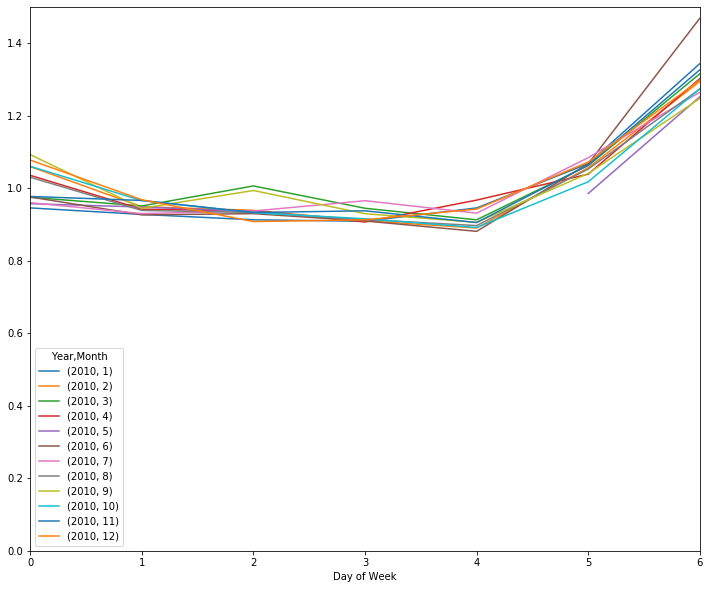

In [22]:
rdr.ptcs[-13503833].data['DoM Factor'].T.plot(figsize=(12,10), ylim=(0, 1.5))

In [23]:
# # https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [24]:
IterativeImputer().fit_transform(rdr.ptcs[-13503833].data['DoM Factor'].values)[4, :]

array([0.95774444, 0.94866279, 0.93627711, 0.9120739 , 0.91600968,
       0.98593491, 1.2526687 ])

In [25]:
rdr.ptcs[-13503833].data['DoM Factor'].values[4, :]

array([0.95774444, 0.94866279, 0.93627711, 0.9120739 ,        nan,
       0.98593491, 1.2526687 ])

### DoMSTTC emulator

In [26]:
# equivalent to isite == 1, which scans through Ms_abs one by one
sttc = rdr.sttcs[-12448867]
want_year = 2019

sttc_current = sttc.data.iloc[0, :]
sttc_dow = sttc_current['Date'].dayofweek
sttc_year = sttc_current['Date'].year

In [27]:
# temp1 and temp2, sort of
neighbours, distances = nb.get_neighbours(sttc.centreline_id)

In [28]:
# We don't need sel_ids, since we store data for each neighbour in its own rdr object.
neighbours

[1821,
 10924071,
 30003562,
 30003565,
 30033763,
 1144030,
 1144036,
 12387683,
 1141572,
 20037402,
 14659244,
 1145202,
 1145376,
 1145405,
 30073955,
 30021784,
 6837747,
 6837741,
 6388019,
 1003]

In [29]:
# GR_STTC=mean(GR(:,1));
growth_rate_citywide = np.mean([v.growth_factor for v in rdr.ptcs.values()])

In [30]:
growth_rate_citywide

1.0222564979935564

In [31]:
# Pick a PTC
i = 2
cptc = rdr.ptcs[neighbours[i]]

In [32]:
# Ratio between AADT and daily count.

# Equivalent to setting D_all
cptc.data['DoY Ratio'] = cptc.data['Daily Count'].loc[:, ['Date']].copy()
for year in cptc.data['Daily Count'].index.levels[0].values:
    cptc.data['DoY Ratio'].loc[year, 'Day-to-AADT Ratio'] = (cptc.data['AADT'].at[year, 'AADT'] /
                                                             cptc.data['Daily Count'].loc[year, 'Daily Count']).values

In [33]:
cptc.data['DoY Ratio'].reset_index(inplace=True)
cptc.data['DoY Ratio']['Month'] = cptc.data['DoY Ratio']['Date'].dt.month
cptc.data['DoY Ratio']['Day of Week'] = cptc.data['DoY Ratio']['Date'].dt.dayofweek

In [34]:
cptc.data['DoY Ratio']['Day of Week'].unique()

array([3, 4, 5, 6, 0, 1, 2])

In [35]:
# If day-of-week exists in cptc, take average for the MADT, DoM Factor, DoMADT and Day-to-AADT ratio,
# weighted by the number of days of week in each month that are the STTC day-of-week, for the closest
# year with the day-of-week available.
cptc_doy_dow = cptc.data['DoY Ratio'].loc[cptc.data['DoY Ratio']['Day of Week'] == sttc_dow, :]

# Number of days of the week in each year and month.
N_days = (cptc.data['DoY Ratio'].reset_index().groupby(['Year', 'Month', 'Day of Week'])['Day-to-AADT Ratio']
          .count().unstack())

if cptc_doy_dow.shape[0]:
    # If there's a tie for the closest year, this takes the closest year BEFORE the STTC
    # year (since unique_years is ordered and np.argmin returns the first smallest value).
    unique_years = cptc_doy_dow['Year'].unique()
    closest_year = unique_years[np.argmin(np.abs(unique_years - sttc_year))]
    
    day_to_aadt_ratio_avg = (cptc_doy_dow
                             .loc[cptc_doy_dow['Year'] == closest_year, 'Day-to-AADT Ratio']
                             .mean(skipna=True))

    # Double loc is shortest way I've discovered to get single-index series.
    weights = N_days.loc[closest_year, :].loc[:, sttc_dow]
    madt_avg = np.average(cptc.data['MADT'].loc[closest_year, 'MADT'][weights.index].values, weights=weights.values)
    dom_avg = np.average(cptc.data['DoM Factor'].loc[closest_year, :].loc[weights.index, sttc_dow], weights=weights.values)
    domadt_avg = np.average(cptc.data['DoMADT'].loc[closest_year, :].loc[weights.index, sttc_dow], weights=weights.values)

    aadt_closest_year = cptc.data['AADT'].at[closest_year, 'AADT']
# If the day of week doesn't exist, just take the averages for the closest year, weighted by all
# the values.
else:
    unique_years = cptc.data['Year'].unique()
    closest_year = unique_years[np.argmin(np.abs(unique_years - sttc_year))]
    day_to_aadt_ratio_avg = (cptc.data['DoY Ratio']
                             .loc[cptc.data['Year'] == closest_year, 'Day-to-AADT Ratio']
                             .mean(skipna=True))

    n_days_closest_year = N_days.loc[closest_year, :]

    madt_weights = n_days_closest_year.sum(axis=1, skipna=True)
    madt_avg = np.average(cptc.data['MADT'].loc[closest_year, 'MADT'][madt_weights.index].values, weights=madt_weights.values)

    dom_closest_year = cptc.data['DoM Factor'].loc[closest_year, :]
    assert np.array_equal(dom_closest_year.index, n_days_closest_year.index)
    assert np.array_equal(dom_closest_year.columns, n_days_closest_year.columns)
    dom_avg = np.average(dom_closest_year.values, weights=n_days_closest_year.values)
    domadt_avg = np.average(cptc.data['DoMADT'].loc[closest_year, :].values, weights=n_days_closest_year.values)
    
    assert np.array_equal(dom_closest_year.index, n_days_closest_year.index)

In [36]:
# Mothballed algos
# Get unique year for each day of week in DoY Ratio
# def closest_year(x, ref_year):
#     unique_years = x.unique()
#     return unique_years[np.argmin(np.abs(unique_years - ref_year))]

# cptc.data['DoY Ratio'].groupby('Day of Week')['Year'].apply(closest_year, ref_year=2010)

# Find all months in the closest year that have data.
# months_to_include = (cptc.data['DoM Factor']
#                      .loc[closest_year:closest_year, sttc_current['Date'].dayofweek]
#                      .dropna()).index.levels[1].values

In [37]:
print(closest_year, day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg, aadt_closest_year)

2015 1.0104020646633725 55582.56399251523 1.0019051284416816 55576.89473684211 54795.58976704318


In [38]:
AADT_prelim = sttc.data['Daily Count'].mean() * day_to_aadt_ratio_avg * growth_rate_citywide**(want_year - sttc_year)
MADT_pj = sttc_current['Daily Count'] * dom_avg * growth_rate_citywide**(want_year - sttc_year)
MF_STTC = MADT_pj / AADT_prelim
MF_PTC = madt_avg / aadt_closest_year

In [39]:
print(AADT_prelim, MADT_pj, MF_STTC, MF_PTC)

146.62200728995828 132.05055537839544 0.9006189303987193 1.0143619993656017


We can simplify this significantly by pre-calculating all these values.

In [40]:
p = cptc

available_years = p.data['Daily Count'].index.levels[0].values

# Get ratio between AADT and daily count
doyr = p.data['Daily Count'].loc[:, ['Date']].copy()
for year in available_years:
    doyr.loc[year, 'Day-to-AADT Ratio'] = (
        p.data['AADT'].at[year, 'AADT'] /
        p.data['Daily Count'].loc[year, 'Daily Count']).values
doyr.reset_index(inplace=True)
doyr['Month'] = doyr['Date'].dt.month
doyr['Day of Week'] = doyr['Date'].dt.dayofweek

# Get day-to-AADT ratios for each day of week and year.
ptc_mse_dow = pd.DataFrame(
    doyr.groupby(['Day of Week', 'Year'])['Day-to-AADT Ratio'].mean())

# Number of days of the week in each year and month.
N_days = (doyr.reset_index()
          .groupby(['Year', 'Month', 'Day of Week'])['Day-to-AADT Ratio']
          .count().unstack())

madt_avg = []
dom_avg = []
domadt_avg = []
for dow, year in ptc_mse_dow.index:
    # Double loc is shortest way I've discovered to get single-index series.
    weights = N_days.loc[year, :].loc[:, dow]

    madt_avg.append(np.average(p.data['MADT'].loc[year, 'MADT'][weights.index].values, weights=weights.values))
    dom_avg.append(np.average(p.data['DoM Factor'].loc[year, :].loc[weights.index, dow], weights=weights.values))
    domadt_avg.append(np.average(p.data['DoMADT'].loc[year, :].loc[weights.index, dow], weights=weights.values))

ptc_mse_dow['MADT Avg.'] = madt_avg
ptc_mse_dow['DoM Factor Avg.'] = dom_avg
ptc_mse_dow['DoMADT Avg.'] = domadt_avg

ptc_mse_yo = pd.DataFrame(doyr.groupby('Year')['Day-to-AADT Ratio'].mean())

madt_avg = []
dom_avg = []
domadt_avg = []
for year in ptc_mse_yo.index:
    n_days_year = N_days.loc[year, :]
    madt_weights = n_days_year.sum(axis=1, skipna=True)

    madt_avg.append(np.average(p.data['MADT'].loc[year, 'MADT'][madt_weights.index].values, weights=madt_weights.values))

    dom_year = cptc.data['DoM Factor'].loc[year, :]
    dom_avg.append(np.average(dom_year.values, weights=n_days_year.values))
    domadt_avg.append(np.average(p.data['DoMADT'].loc[year, :].values, weights=n_days_year.values))

ptc_mse_yo['MADT Avg.'] = madt_avg
ptc_mse_yo['DoM Factor Avg.'] = dom_avg
ptc_mse_yo['DoMADT Avg.'] = domadt_avg

In [41]:
ptc_mse_dow

Day-to-AADT Ratio     MADT Avg.  DoM Factor Avg.  \
Day of Week Year                                                     
0           2015           1.068553  54692.167563         1.039158   
            2017           1.058912  67177.916112         1.052730   
1           2015           1.010402  55582.563993         1.001905   
            2017           1.007326  67273.239144         1.005181   
2           2015           0.990975  54408.254528         0.961752   
            2017           0.968099  67514.796618         0.973550   
3           2015           0.979500  54678.696562         0.956108   
            2017           0.962646  67045.318868         0.960835   
4           2015           0.971518  54852.227539         0.945926   
            2017           0.958609  66779.698022         0.951008   
5           2015           1.043909  55525.343539         1.031844   
            2017           1.002521  66952.228614         0.998647   
6           2015           1.123496  55569.502271         1.112164   
            2017           1.098232  67014.672188         1.087930   

                   DoMADT Avg.  
Day of Week Year                
0           2015  52667.513514  
            2017  63886.052632  
1           2015  55576.894737  
            2017  67049.804878  
2           2015  56690.523810  
            2017  69344.950000  
3           2015  57199.000000  
            2017  69791.463415  
4           2015  58075.425000  
            2017  70233.568182  
5           2015  53899.500000  
            2017  67061.369565  
6           2015  50127.371429  
            2017  61667.564103

In [42]:
ptc_mse_yo

,Day-to-AADT Ratio,MADT Avg.,DoM Factor Avg.,DoMADT Avg.
Year,,,,
2015,1.024201,55027.135036,1.004043,55027.135036
2017,1.006427,67100.674740,1.002643,67100.674740


In [43]:
if sttc_dow in ptc_mse_dow.index.levels[0]:
    unique_years = ptc_mse_dow.loc[sttc_dow].index.values
    closest_year = unique_years[
                        np.argmin(np.abs(unique_years - sttc_year))]
ptc_mse_dow.loc[(sttc_dow, closest_year)]

Day-to-AADT Ratio        1.010402
MADT Avg.            55582.563993
DoM Factor Avg.          1.001905
DoMADT Avg.          55576.894737
Name: (1, 2015), dtype: float64

## Functionalize DoMSTTC emulator

In [44]:
def nanaverage(x, axis=None, weights=None):
    if weights is None:
        return np.nanmean(x)
    notnull = ~(np.isnan(x) | np.isnan(weights))
    return np.average(x[notnull], axis=axis, weights=weights[notnull])

x = np.random.randint(0, 331, 144).astype(float).reshape(12,12)
w = np.random.rand(144).reshape(12,12)
x[7, 1] = x[9, 2] = x[3, 1] = np.nan
w[2, 2] = np.nan

xr = x.ravel()
wr = w.ravel()
rnotnull = ~(np.isnan(xr) | np.isnan(wr))
assert np.isclose(np.average(xr[rnotnull], weights=wr[rnotnull]), nanaverage(x, weights=w), atol=1e-8, rtol=1e-10)

In [45]:
def mse_preprocess_ptc_loop(p):
    available_years = p.data['Daily Count'].index.levels[0].values

    # Get ratio between AADT and daily count
    doyr = p.data['Daily Count'].loc[:, ['Date']].copy()
    for year in available_years:
        doyr.loc[year, 'Day-to-AADT Ratio'] = (
            p.data['AADT'].at[year, 'AADT'] /
            p.data['Daily Count'].loc[year, 'Daily Count']).values
    doyr.reset_index(inplace=True)
    doyr['Month'] = doyr['Date'].dt.month
    doyr['Day of Week'] = doyr['Date'].dt.dayofweek
    
    # Number of days of the week in each year and month.  Fill NaNs with
    # 0.
    N_days = (doyr.reset_index()
              .groupby(['Year', 'Month', 'Day of Week'])['Day-to-AADT Ratio']
              .count().unstack(fill_value=0.))

    # Create two arrays - first breaks down values by day-of-week and year.
    # First, get day-to-AADT ratios for each day of week and year.
    ptc_mse_ydow = pd.DataFrame(
        doyr.groupby(['Day of Week', 'Year'])['Day-to-AADT Ratio'].mean())

    # Then, for each day-of-week, calculate MADT, DoMADT, etc. averages
    # weighted by number of days-of-the-week available in the month.
    madt_avg = []
    dom_avg = []
    domadt_avg = []
    for dow, year in ptc_mse_ydow.index:
        # Double loc is shortest way I've discovered to get single-index
        # series.
        weights = N_days.loc[year, :].loc[:, dow]

        madt_avg.append(np.average(
            p.data['MADT'].loc[year, 'MADT'][weights.index].values,
            weights=weights.values))
        dom_avg.append(nanaverage(
            p.data['DoM Factor'].loc[year, :].loc[weights.index, dow],
            weights=weights.values))
        domadt_avg.append(nanaverage(
            p.data['DoMADT'].loc[year, :].loc[weights.index, dow],
            weights=weights.values))
        
    ptc_mse_ydow['MADT Avg.'] = madt_avg
    ptc_mse_ydow['DoM Factor Avg.'] = dom_avg
    ptc_mse_ydow['DoMADT Avg.'] = domadt_avg
    
    if (ptc_mse_ydow['MADT Avg.'].isnull().values.any() or
            ptc_mse_ydow['DoM Factor Avg.'].isnull().values.any() or
            ptc_mse_ydow['DoM Factor Avg.'].isnull().values.any()):
        raise ValueError("yeah, you shouldn't be getting nulls for ydow tables.")

    # Now, create a second array that breaks down the same values but only
    # by year.
    ptc_mse_yo = pd.DataFrame(doyr.groupby('Year')['Day-to-AADT Ratio'].mean())

    madt_avg = []
    dom_avg = []
    domadt_avg = []
    for year in ptc_mse_yo.index:
        n_days_year = N_days.loc[year, :]
        madt_weights = n_days_year.sum(axis=1, skipna=True)

        madt_avg.append(np.average(
            p.data['MADT'].loc[year, 'MADT'][madt_weights.index].values,
            weights=madt_weights.values))

        dom_year = p.data['DoM Factor'].loc[year, :]
        dom_avg.append(nanaverage(
            dom_year.values, weights=n_days_year.values))
        domadt_avg.append(nanaverage(
            p.data['DoMADT'].loc[year, :].values, weights=n_days_year.values))

    ptc_mse_yo['MADT Avg.'] = madt_avg
    ptc_mse_yo['DoM Factor Avg.'] = dom_avg
    ptc_mse_yo['DoMADT Avg.'] = domadt_avg

    if (ptc_mse_yo['MADT Avg.'].isnull().values.any() or
            ptc_mse_yo['DoM Factor Avg.'].isnull().values.any() or
            ptc_mse_yo['DoM Factor Avg.'].isnull().values.any()):
        raise ValueError("yeah, you shouldn't be getting nulls for yo tables.")

    return doyr, ptc_mse_ydow, ptc_mse_yo

def mse_preprocess_ptcs(ptcs):
    for p in ptcs.values():
        doyr, ptc_mse_ydow, ptc_mse_yo = mse_preprocess_ptc_loop(p)
        p.mse_pp = {
            'Day-to-AADT': doyr,
            'MSE_yDoW': ptc_mse_ydow,
            'MSE_y': ptc_mse_yo
        }

In [46]:
%time mse_preprocess_ptcs(rdr.ptcs)

CPU times: user 11.1 s, sys: 46.9 ms, total: 11.1 s
Wall time: 11.2 s


In [47]:
rdr.ptcs[-14659244].mse_pp['MSE_yDoW']['MADT Avg.']

Day of Week  Year
0            2016    61749.335615
             2017    65757.895715
1            2016    62107.885762
             2017    66036.918700
2            2016    62268.364153
             2017    66266.989998
3            2016    62064.151711
             2017    65807.936955
4            2016    62042.461049
             2017    65614.351926
5            2016    61664.922185
             2017    65795.872291
6            2016    61652.486542
             2017    65766.353726
Name: MADT Avg., dtype: float64

In [48]:
rdr.ptcs[8540609].mse_pp

{'Day-to-AADT':       Year  Day of Year       Date  Day-to-AADT Ratio  Month  Day of Week
 0     2006            1 2006-01-01          16.869598      1            6
 1     2006            2 2006-01-02           8.640526      1            0
 2     2006            3 2006-01-03           2.976988      1            1
 3     2006            4 2006-01-04           3.290355      1            2
 4     2006            5 2006-01-05           3.342090      1            3
 5     2006            6 2006-01-06           3.352633      1            4
 6     2006            7 2006-01-07           7.701338      1            5
 7     2006            8 2006-01-08           7.814593      1            6
 8     2006            9 2006-01-09           2.697423      1            0
 9     2006           10 2006-01-10           1.946492      1            1
 10    2006           11 2006-01-11           2.242162      1            2
 11    2006           12 2006-01-12           1.786193      1            3
 12    200

In [49]:
tc_dc = rdr.sttcs[-175].data.reset_index()
tc_dc['Day of Week'] = tc_dc['Date'].dt.dayofweek

for i, row in tc_dc.iterrows():
    ryear, rdow = row['Year'], row['Day of Week']
    print(ryear, rdow, rdow in rdr.ptcs[neighbours[2]].mse_pp['MSE_yDoW'].index.levels[0])

2006 1 True
2010 2 True


In [50]:
rdr.ptcs[neighbours[2]].mse_pp['MSE_yDoW'].loc[(0, 2015)]

Day-to-AADT Ratio        1.068553
MADT Avg.            54692.167563
DoM Factor Avg.          1.039158
DoMADT Avg.          52667.513514
Name: (0, 2015), dtype: float64

In [51]:
day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg = rdr.ptcs[neighbours[2]].mse_pp['MSE_yDoW'].loc[(0, 2015)]

In [52]:
print(day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg)

1.0685530229889628 54692.16756335768 1.0391578074151713 52667.51351351351


In [53]:
rdr.ptcs[neighbours[2]].mse_pp['MSE_yDoW'].loc[0].index

Int64Index([2015, 2017], dtype='int64', name='Year')

In [54]:
# equivalent to isite == 1, which scans through Ms_abs one by one
sttc = rdr.sttcs[-12448867]
want_year = 2019

sttc_current = sttc.data.iloc[0, :]
sttc_dow = sttc_current['Date'].dayofweek
sttc_year = sttc_current['Date'].year

AADT_prelim = sttc.data['Daily Count'].mean() * day_to_aadt_ratio_avg * growth_rate_citywide**(want_year - sttc_year)
MADT_pj = sttc_current['Daily Count'] * dom_avg * growth_rate_citywide**(want_year - sttc_year)
MF_STTC = MADT_pj / AADT_prelim
MF_PTC = madt_avg / aadt_closest_year

In [55]:
rdr.ptcs[neighbours[2]].mse_pp['MSE_y'].loc[2015]

Day-to-AADT Ratio        1.024201
MADT Avg.            55027.135036
DoM Factor Avg.          1.004043
DoMADT Avg.          55027.135036
Name: 2015, dtype: float64

In [56]:
tc_dc

,Year,Day of Year,Date,Daily Count,Day of Week
0,2006,227,2006-08-15,171.0,1
1,2010,160,2010-06-09,1855.0,2


In [57]:
tc_dc

,Year,Day of Year,Date,Daily Count,Day of Week
0,2006,227,2006-08-15,171.0,1
1,2010,160,2010-06-09,1855.0,2


In [58]:
tc = rdr.sttcs[-12448867]
rptcs = rdr.ptcs
# Find neighbouring PTCs by first finding neighbouring centreline IDs,
# then checking if either direction exists in rptcs.
neighbours, distances = nb.get_neighbours(tc.centreline_id)
neighbour_ptcs = [rptcs[n] for n in
                  [-nbrs for nbrs in neighbours] + neighbours
                  if n in rptcs.keys()]

# Declare the columns in the final saved data frame.
tc_year = []
tc_dayofyear = []
tc_ptcid = []
tc_day_to_aadt_ratio_avg = []
tc_madt_avg = []
tc_dom_avg = []
tc_domadt_avg = []
tc_closest_year = []
tc_aadt_closest_year = []

tc_dc = tc.data.reset_index()
tc_dc['Day of Week'] = tc_dc['Date'].dt.dayofweek

for i, row in tc_dc.iterrows():
    ryear, rdow = row['Year'], row['Day of Week']

    for p in neighbour_ptcs:

        if rdow in p.mse_pp['MSE_yDoW'].index.levels[0]:
            unique_years = p.mse_pp['MSE_yDoW'].loc[rdow].index.values
            closest_year = unique_years[np.argmin(
                np.abs(unique_years - ryear))]

            (day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg) = (
               p.mse_pp['MSE_yDoW'].loc[(rdow, closest_year)])
        else:
            # Levels contain all unique years regardless if each is
            # available for every day-of-week.
            unique_years = p.mse_pp['MSE_yDoW'].index.levels[1].values
            closest_year = unique_years[np.argmin(
                np.abs(unique_years - ryear))]

            (day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg) = (
               p.mse_pp['MSE_y'].loc[closest_year])

        aadt_closest_year = p.data['AADT'].at[closest_year, 'AADT']

        tc_year.append(ryear)
        tc_dayofyear.append(row['Day of Year'])
        tc_ptcid.append(p.count_id)
        tc_day_to_aadt_ratio_avg.append(day_to_aadt_ratio_avg)
        tc_madt_avg.append(madt_avg)
        tc_dom_avg.append(dom_avg)
        tc_domadt_avg.append(domadt_avg)
        tc_closest_year.append(closest_year)
        tc_aadt_closest_year.append(aadt_closest_year)

In [59]:
tc_mse = pd.DataFrame({
    'Year': tc_year,
    'Day of Year': tc_dayofyear,
    'PTC ID': tc_ptcid,
    'PTC Day-to-AADT Ratio': tc_day_to_aadt_ratio_avg,
    'PTC MADT Avg.': tc_madt_avg,
    'PTC DoM Factor Avg.': tc_dom_avg,
    'PTC DoMADT Avg.': tc_domadt_avg,
    'PTC Closest Year AADT': tc_aadt_closest_year
})

In [60]:
tc_mse = pd.merge(tc_dc, tc_mse, on=('Year', 'Day of Year'))

# I disagree with this, but line 95 of DoMSTTC.m seems to do it.
mean_tc_count = tc_dc['Daily Count'].mean()

tc_mse['AADT_prelim'] = (
    mean_tc_count * tc_mse['PTC Day-to-AADT Ratio'] *
    growth_rate_citywide**(want_year - tc_mse['Year']))
tc_mse['MADT_pj'] = (
    tc_mse['Daily Count'] * tc_mse['PTC DoM Factor Avg.'] *
    growth_rate_citywide**(want_year - tc_mse['Year']))
tc_mse['MF_STTC'] = tc_mse['MADT_pj'] / tc_mse['AADT_prelim']
tc_mse['MF_PTC'] = (tc_mse['PTC MADT Avg.'] /
                    tc_mse['PTC Closest Year AADT'])

tc.tc_mse = tc_mse

In [61]:
tc_mse 

,Year,Day of Year,Date,Daily Count,Day of Week,PTC ID,PTC Day-to-AADT Ratio,PTC MADT Avg.,PTC DoM Factor Avg.,PTC DoMADT Avg.,PTC Closest Year AADT,AADT_prelim,MADT_pj,MF_STTC,MF_PTC
0,2006,318,2006-11-14,99.0,1,-10924071,0.957897,4332.333812,0.948225,4574.520833,4349.017096,139.002801,124.975546,0.899087,0.996164
1,2006,318,2006-11-14,99.0,1,-30003565,0.989962,54644.956693,0.981561,55742.868421,54092.216417,143.655852,129.369220,0.900550,1.010218
2,2006,318,2006-11-14,99.0,1,-1144036,0.941759,32080.054231,0.938603,34198.500000,32133.694571,136.661092,123.707304,0.905212,0.998331
3,2006,318,2006-11-14,99.0,1,-12387683,0.938541,17950.165244,0.936037,19187.025000,17953.196474,136.194042,123.369114,0.905833,0.999831
4,2006,318,2006-11-14,99.0,1,-1141572,1.019948,11137.397758,1.010116,11030.948718,11154.323910,148.007303,133.132752,0.899501,0.998483
5,2006,318,2006-11-14,99.0,1,-20037402,0.977424,7269.727415,0.974087,7461.600000,7226.875265,141.836446,128.384132,0.905156,1.005930
6,2006,318,2006-11-14,99.0,1,-14659244,0.974103,62107.885762,0.962351,64610.547619,62249.432956,141.354547,126.837350,0.897299,0.997726
7,2006,318,2006-11-14,99.0,1,-1145202,0.953080,6940.784142,0.953524,7266.048780,6827.877079,138.303875,125.673992,0.908680,1.016536
8,2006,318,2006-11-14,99.0,1,-1145405,0.956746,22317.024762,0.953204,23412.700000,22381.673027,138.835773,125.631735,0.904895,0.997112
9,2006,318,2006-11-14,99.0,1,-30021784,0.946879,6984.960600,0.963132,7243.189189,6662.478467,137.404026,126.940234,0.923847,1.048403


In [62]:
tc = rdr.sttcs[-907123]

In [63]:
nb.get_neighbours(907123)
neighbour_ptcs = [rptcs[n] for n in
                  [tc.direction * nbrs for nbrs in neighbours]
                  if n in rptcs.keys()]

In [64]:
neighbour_ptcs[0].mse_pp['MSE_yDoW']

Day-to-AADT Ratio    MADT Avg.  DoM Factor Avg.  DoMADT Avg.
Day of Week Year                                                              
0           2010           1.069780  4339.225353         1.039729  4190.733333
            2012           1.052331  3663.591912         1.026437  3573.653846
            2013           1.052179  3660.447411         1.028269  3565.229167
            2014           1.041514  3611.380016         1.019230  3547.711538
1           2010           0.957897  4332.333812         0.948225  4574.520833
            2012           0.964579  3663.648829         0.952924  3845.816327
            2013           0.962946  3659.458593         0.950910  3850.509804
            2014           0.965086  3612.362088         0.959216  3766.211538
2           2010           0.941456  4333.016394         0.933164  4645.422222
            2012           0.945230  3686.443486         0.938075  3933.020833
            2013           0.949685  3666.621619         0.938135  3912.882353
            2014           0.976331  3605.081468         0.958077  3773.830189
3           2010           0.946124  4325.943099         0.934943  4630.340426
            2012           0.930090  3671.969993         0.922081  3984.000000
            2013           0.933638  3672.851600         0.923615  3979.627451
            2014           0.952283  3606.642685         0.940149  3844.686275
4           2010           0.916936  4315.520856         0.904408  4772.000000
            2012           0.915931  3681.904485         0.910842  4044.235294
            2013           0.933506  3666.911630         0.918539  3998.826923
            2014           0.916651  3618.251161         0.906300  3996.392157
5           2010           1.098142  4320.050390         1.073053  4038.204545
            2012           1.087571  3676.342364         1.079535  3406.134615
            2013           1.094858  3660.660224         1.084041  3379.862745
            2014           1.075566  3612.669019         1.064472  3394.823529
6           2010           1.267456  4343.829539         1.255194  3462.630435
            2012           1.239918  3665.729800         1.226962  2990.207547
            2013           1.247311  3662.537033         1.235613  2964.134615
            2014           1.234868  3609.565128         1.221747  2956.711538

In [65]:
def get_normalized_seasonal_patterns(tcs, rptcs, want_year):
    """Get normalized seasonal patterns for `tcs`.

    For STTCs, get best estimate normalized patterns and corresponding PTC
    normalized patterns to check for MSE (Eqn. 6 in Bagheri).  For PTCs, get
    best estimate from nearby PTCs and check as a part of validation.
    """
    growth_rate_citywide = np.mean([v.growth_factor for v in rptcs.values()])

    for tc in tcs.values():
        # Find neighbouring PTCs by first finding neighbouring centreline IDs,
        # then checking if either direction exists in rptcs.
        neighbours, distances = nb.get_neighbours(tc.centreline_id)
        
        # We can consider both directions if we want, but this is supposed
        # to emulate PRTCS.
#         neighbour_ptcs = [rptcs[n] for n in
#                           [-nbrs for nbrs in neighbours] + neighbours
#                           if n in rptcs.keys()]
        neighbour_ptcs = [rptcs[n] for n in
                          [tc.direction * nbrs for nbrs in neighbours]
                          if n in rptcs.keys()][:5]

        if len(neighbour_ptcs) != 5:
            raise ValueError("selected a weird number of PTC locations!")

        # Declare the columns in the final saved data frame.
        tc_year = []
        tc_dayofyear = []
        tc_ptcid = []
        tc_day_to_aadt_ratio_avg = []
        tc_madt_avg = []
        tc_dom_avg = []
        tc_domadt_avg = []
        tc_closest_year = []
        tc_aadt_closest_year = []

        if tc.is_permanent:
            tc_dc = tc.data['Daily Count'].reset_index()
        else:
            tc_dc = tc.data.reset_index()
        tc_dc['Day of Week'] = tc_dc['Date'].dt.dayofweek

        for i, row in tc_dc.iterrows():
            ryear, rdow = row['Year'], row['Day of Week']

            for p in neighbour_ptcs:

                if rdow in p.mse_pp['MSE_yDoW'].index.levels[0]:
                    unique_years = p.mse_pp['MSE_yDoW'].loc[rdow].index.values
                    closest_year = unique_years[np.argmin(
                        np.abs(unique_years - ryear))]

                    (day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg) = (
                       p.mse_pp['MSE_yDoW'].loc[(rdow, closest_year)])
                else:
                    # Levels contain all unique years regardless if each is
                    # available for every day-of-week.
                    unique_years = p.mse_pp['MSE_yDoW'].index.levels[1].values
                    closest_year = unique_years[np.argmin(
                        np.abs(unique_years - ryear))]

                    (day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg) = (
                       p.mse_pp['MSE_y'].loc[closest_year])
                
                if madt_avg is np.nan:
                    raise ValueError("ummmmm, this can't be NaN.")

                aadt_closest_year = p.data['AADT'].at[closest_year, 'AADT']

                tc_year.append(ryear)
                tc_dayofyear.append(row['Day of Year'])
                tc_ptcid.append(p.count_id)
                tc_day_to_aadt_ratio_avg.append(day_to_aadt_ratio_avg)
                tc_madt_avg.append(madt_avg)
                tc_dom_avg.append(dom_avg)
                tc_domadt_avg.append(domadt_avg)
                tc_closest_year.append(closest_year)
                tc_aadt_closest_year.append(aadt_closest_year)

        tc_mse = pd.DataFrame({
            'Year': tc_year,
            'Day of Year': tc_dayofyear,
            'PTC ID': tc_ptcid,
            'PTC Day-to-AADT Ratio': tc_day_to_aadt_ratio_avg,
            'PTC MADT Avg.': tc_madt_avg,
            'PTC DoM Factor Avg.': tc_dom_avg,
            'PTC DoMADT Avg.': tc_domadt_avg,
            'PTC Closest Year AADT': tc_aadt_closest_year
        })

        tc_mse = pd.merge(tc_dc, tc_mse, on=('Year', 'Day of Year'))

        # I disagree with this, but line 95 of DoMSTTC.m seems to do it.
        mean_tc_count = tc_dc['Daily Count'].mean()

        tc_mse['AADT_prelim'] = (
            mean_tc_count * tc_mse['PTC Day-to-AADT Ratio'] *
            growth_rate_citywide**(want_year - tc_mse['Year']))
        tc_mse['MADT_pj'] = (
            tc_mse['Daily Count'] * tc_mse['PTC DoM Factor Avg.'] *
            growth_rate_citywide**(want_year - tc_mse['Year']))
        tc_mse['MF_STTC'] = tc_mse['MADT_pj'] / tc_mse['AADT_prelim']
        tc_mse['MF_PTC'] = (tc_mse['PTC MADT Avg.'] /
                            tc_mse['PTC Closest Year AADT'])

        tc.tc_mse = tc_mse

In [66]:
%time get_normalized_seasonal_patterns(rdr.sttcs, rdr.ptcs, 2018)

CPU times: user 19min 54s, sys: 1.08 s, total: 19min 55s
Wall time: 19min 56s


In [67]:
%time get_normalized_seasonal_patterns(rdr.ptcs, rdr.ptcs, 2018)

CPU times: user 4min 32s, sys: 156 ms, total: 4min 32s
Wall time: 4min 33s


In [68]:
rdr.ptcs[8540609].tc_mse

,Year,Day of Year,Date,Daily Count,Day of Week,PTC ID,PTC Day-to-AADT Ratio,PTC MADT Avg.,PTC DoM Factor Avg.,PTC DoMADT Avg.,PTC Closest Year AADT,AADT_prelim,MADT_pj,MF_STTC,MF_PTC
0,2006,1,2006-01-01,63.0,6,30073955,1.125202,64756.184367,1.109389,58461.846154,64941.796028,1693.189364,91.021278,0.053757,0.997142
1,2006,1,2006-01-01,63.0,6,30003562,1.123496,55569.502271,1.112164,50127.371429,54795.589767,1690.622051,91.248965,0.053974,1.014124
2,2006,1,2006-01-01,63.0,6,6837747,1.280082,9585.251713,1.259559,7626.410256,9630.369914,1926.250165,103.342199,0.053649,0.995315
3,2006,1,2006-01-01,63.0,6,30033763,1.219087,4345.117921,1.190493,3657.000000,4380.833905,1834.466834,97.675588,0.053245,0.991847
4,2006,1,2006-01-01,63.0,6,1144030,1.172330,48233.243580,1.145882,42162.261905,48484.235706,1764.107145,94.015375,0.053293,0.994823
5,2006,2,2006-01-02,123.0,0,30073955,1.029846,64914.225656,1.026714,63271.921053,64941.796028,1549.698563,164.464869,0.106127,0.999575
6,2006,2,2006-01-02,123.0,0,30003562,1.068553,54692.167563,1.039158,52667.513514,54795.589767,1607.944542,166.458192,0.103522,0.998113
7,2006,2,2006-01-02,123.0,0,6837747,1.020424,9614.880968,1.006859,9574.210526,9630.369914,1535.521010,161.284396,0.105036,0.998392
8,2006,2,2006-01-02,123.0,0,30033763,1.053004,4360.202772,1.025954,4262.146341,4380.833905,1584.545937,164.343117,0.103716,0.995291
9,2006,2,2006-01-02,123.0,0,1144030,1.034338,48387.578597,1.027302,47123.119048,48484.235706,1556.458369,164.559089,0.105727,0.998006


## MSE Calculator

- Get mean squared error for each STTC/PTC pair (regardless of year)
- Get mean D_ij for each STTC/PTC pair (regardless of year)
- Then for each STTC:
  - Determine the PTC that gives the minimum MSE.  Use the D_ij from that PTC.
  - Find the closest year of counts to the want_year
  - Find the mean daily traffic, mean PTC AADT, and mean growth factor (all these means are row-by-row, and many are means of the same number since there's a lot of repetition in DoM_STTC)
  - Get the growth rate; right now it's *still* the global growth rate averaged over all PTCs.
  - Determine an AADT estimate using Mean daily traffic of closest year * Dij(minimum MSE PTC station) * GR ^ (want_year - closest_year)
- For each PTC:
  - Find the year closest to wanted year
  - Find the mean daily traffic (averaged over rows, with no heed taken to weight by monthly representation)
  - Find the mean growth factor for that station
  - Determine an AADT estimate using mean daily traffic * GR^(want_year - closest_year)

In [69]:
rdr.sttcs[117].tc_mse

,Year,Day of Year,Date,Daily Count,Day of Week,PTC ID,PTC Day-to-AADT Ratio,PTC MADT Avg.,PTC DoM Factor Avg.,PTC DoMADT Avg.,PTC Closest Year AADT,AADT_prelim,MADT_pj,MF_STTC,MF_PTC
0,2009,63,2009-03-04,1236.0,2,1033,0.975932,74875.398171,0.974378,76903.711111,74771.768446,1480.057825,1468.198071,0.991987,1.001386
1,2009,63,2009-03-04,1236.0,2,446012,0.905438,17404.933889,0.862139,20272.557692,17382.176328,1373.150129,1299.075730,0.946055,1.001309
2,2009,63,2009-03-04,1236.0,2,444516,0.931978,1716.942730,0.902882,1911.441860,1718.241066,1413.399523,1360.468824,0.962551,0.999244
3,2009,63,2009-03-04,1236.0,2,444782,0.997230,65950.264092,0.995287,66298.409091,65963.771956,1512.358601,1499.704027,0.991633,0.999795
4,2009,63,2009-03-04,1236.0,2,1003,0.975810,3340.586895,0.967456,3459.525000,3350.164546,1479.872898,1457.769047,0.985064,0.997141
5,2010,160,2010-06-09,1252.0,2,1033,0.975932,74875.398171,0.974378,76903.711111,74771.768446,1447.834109,1454.824571,1.004828,1.001386
6,2010,160,2010-06-09,1252.0,2,446012,0.905438,17404.933889,0.862139,20272.557692,17382.176328,1343.253999,1287.242729,0.958302,1.001309
7,2010,160,2010-06-09,1252.0,2,444516,0.931978,1716.942730,0.902882,1911.441860,1718.241066,1382.627086,1348.076607,0.975011,0.999244
8,2010,160,2010-06-09,1252.0,2,444782,0.997230,65950.264092,0.995287,66298.409091,65963.771956,1479.431634,1486.043547,1.004469,0.999795
9,2010,160,2010-06-09,1252.0,2,1003,0.975810,3340.586895,0.967456,3459.525000,3350.164546,1447.653207,1444.490542,0.997815,0.997141


In [70]:
rdr.sttcs[117].tc_mse['Square Deviation'] = (
    rdr.sttcs[117].tc_mse['MF_STTC'] - rdr.sttcs[117].tc_mse['MF_PTC'])**2

In [71]:
rdr.sttcs[117].tc_mse.groupby('PTC ID')[['Square Deviation', 'PTC Day-to-AADT Ratio']].mean()

,Square Deviation,PTC Day-to-AADT Ratio
PTC ID,,
1003,0.000073,0.975810
1033,0.000050,0.975932
444516,0.000967,0.931978
444782,0.000044,0.997230
446012,0.002451,0.905438


In [72]:
ptc_dijs = (rdr.sttcs[117].tc_mse
            .groupby('PTC ID')[['Square Deviation', 'PTC Day-to-AADT Ratio']]
            .mean())
id_min_mse_ptc = ptc_dijs['Square Deviation'].idxmin()
dij_min_mse_ptc = ptc_dijs.at[id_min_mse_ptc, 'PTC Day-to-AADT Ratio']

In [73]:
print(id_min_mse_ptc, dij_min_mse_ptc)

444782 0.9972303365088778


In [74]:
sttc_years = rdr.sttcs[117].data.index.levels[0].values
closest_year = sttc_years[np.abs(want_year - sttc_years).argmin()]

In [75]:
growth_rate_citywide = np.mean([v.growth_factor for v in rdr.ptcs.values()])

In [76]:
sttc_avg_daily_count_closest_year = rdr.sttcs[117].data.loc[closest_year]['Daily Count'].mean()

In [77]:
aadt_estimate = (sttc_avg_daily_count_closest_year * dij_min_mse_ptc *
                 growth_rate_citywide**(want_year - closest_year))

In [78]:
aadt_estimate

1522.0843795153899

In [79]:
ptc_years = rdr.ptcs[8540609].data['AADT'].index.values
closest_year = ptc_years[np.abs(want_year - ptc_years).argmin()]
ptc_avg_daily_count_cy = rdr.ptcs[8540609].data['Daily Count'].loc[closest_year]['Daily Count'].mean()
aadt_estimate = ptc_avg_daily_count_cy * rdr.ptcs[8540609].growth_factor**(want_year - closest_year)

In [80]:
aadt_estimate

1173.110498508859

### Functionalize AADT Estimator

In [81]:
def get_aadt_estimates_sttc(rdr, want_year):

    sttc_count_id = []
    sttc_ptc_id_minmse = []
    sttc_dij_minmse = []
    sttc_closest_year = []
    sttc_aadt_est = []
    
    # Average of all PTC growth rates.
    sttc_gr = np.mean([v.growth_factor for v in rdr.ptcs.values()])

    for tc in rdr.sttcs.values():
        # Calculate pointwise square error between STTC and neighbouring PTCs,
        # ignoring year.
        tc.tc_mse['Square Deviation'] = (
            tc.tc_mse['MF_STTC'] - tc.tc_mse['MF_PTC'])**2

        # Determine minimum MSE between STTC and each PTC.
        dijs = (tc.tc_mse
                .groupby('PTC ID')[['Square Deviation',
                                    'PTC Day-to-AADT Ratio']]
                .mean())
        ptcid_mmse = dijs['Square Deviation'].idxmin()
        dij_mmseptc = dijs.at[ptcid_mmse, 'PTC Day-to-AADT Ratio']
        
        # Determine average daily count for most recent year to wanted year.
        sttc_years = tc.data.index.levels[0].values
        closest_year = sttc_years[np.abs(want_year - sttc_years).argmin()]
        sttc_daily_count_cyavg = tc.data.loc[closest_year]['Daily Count'].mean()
        
        aadt_estimate = (
            sttc_daily_count_cyavg * dij_mmseptc *
            sttc_gr**(want_year - closest_year))
        
        # Add to lists.
        sttc_count_id.append(tc.count_id)
        sttc_ptc_id_minmse.append(ptcid_mmse)
        sttc_dij_minmse.append(dij_mmseptc)
        sttc_closest_year.append(closest_year)
        sttc_aadt_est.append(aadt_estimate)
        
    sttc_aadt = pd.DataFrame({
        'Count ID': sttc_count_id,
        'PTC ID': sttc_ptc_id_minmse,
        'D_ij': sttc_dij_minmse,
        'Closest Year': sttc_closest_year,
        'AADT Estimate': sttc_aadt_est})

    ptc_count_id = []
    ptc_closest_year = []
    ptc_growth_factor = []
    ptc_aadt_estimate = []
    
    for tc in rdr.ptcs.values():
        ptc_years = tc.data['AADT'].index.values
        closest_year = ptc_years[np.abs(want_year - ptc_years).argmin()]
        ptc_daily_count_cyavg = tc.data['Daily Count'].loc[closest_year]['Daily Count'].mean()
        aadt_estimate = ptc_daily_count_cyavg * tc.growth_factor**(want_year - closest_year)
        
        ptc_count_id.append(tc.count_id)
        ptc_closest_year.append(closest_year)
        ptc_growth_factor.append(tc.growth_factor)
        ptc_aadt_estimate.append(aadt_estimate)
        
    ptc_aadt = pd.DataFrame({
        'Count ID': ptc_count_id,
        'Closest Year': ptc_closest_year,
        'Growth Factor': ptc_growth_factor,
        'AADT Estimate': ptc_aadt_estimate})

    return sttc_aadt, ptc_aadt

In [82]:
%time sttc_aadt, ptc_aadt = get_aadt_estimates_sttc(rdr, 2019)

CPU times: user 49.1 s, sys: 406 ms, total: 49.5 s
Wall time: 49.5 s


In [83]:
ptc_aadt

,Count ID,Closest Year,Growth Factor,AADT Estimate
0,8540609,2017,1.011970,1173.110499
1,-890,2010,1.038726,99379.139680
2,1003,2016,1.036831,4651.417462
3,1821,2014,0.999093,5632.535402
4,-104870,2012,0.986010,15235.365819
5,105654,2012,0.984415,21300.234927
6,-440789,2012,0.999967,13893.544103
7,-440946,2012,0.964866,11020.238456
8,440946,2010,1.082418,25799.250053
9,-442161,2012,0.983852,29250.587434


In [84]:
sttc_aadt

,Count ID,PTC ID,D_ij,Closest Year,AADT Estimate
0,-175,-445884,0.976424,2010,2208.113549
1,175,446012,0.915809,2010,1818.715350
2,-201,-443987,0.937714,2006,339.977238
3,201,445280,0.984605,2006,267.842517
4,-202,-443975,0.980700,2006,213.250136
5,202,445280,0.984605,2006,243.810970
6,-214,-1022,0.964907,2011,3281.430923
7,-229,-443987,0.937714,2006,357.870777
8,229,444782,0.995233,2006,310.040831
9,-256,-443975,0.962607,2006,15733.294198


## Do Some Analysis

In [85]:
import geopandas as gpd
import matplotlib.colors as colors

sql_query = ("SELECT centreline_id, fcode_desc, geom, lon, lat,"
             "ST_SetSRID(ST_MakePoint(lon, lat), 4326) point_geom "
             "FROM {table}").format(table=ll_conn.tablename)
ctrline_geoms = gpd.read_postgis(sql_query, ll_conn.connect())

In [86]:
sttc_aadt['Centreline ID'] = sttc_aadt['Count ID'].abs()
ptc_aadt['Centreline ID'] = ptc_aadt['Count ID'].abs()

aadt_estimates = (
    pd.concat([sttc_aadt.loc[sttc_aadt['Count ID'].apply(lambda x: x not in ptc_aadt['Count ID']),
                             ['Count ID', 'Centreline ID', 'AADT Estimate']],
    ptc_aadt.loc[:, ['Count ID', 'Centreline ID', 'AADT Estimate']]]).reset_index(drop=True))

aadt_estimates = pd.merge(
    ctrline_geoms[['centreline_id', 'geom', 'lon', 'lat']],
    (aadt_estimates.groupby('Centreline ID')[['AADT Estimate']]
     .mean().reset_index()), how='inner',
    left_on='centreline_id', right_on='Centreline ID')
aadt_estimates = gpd.GeoDataFrame(aadt_estimates, crs={'init': 'epsg:4326'}, geometry='geom')

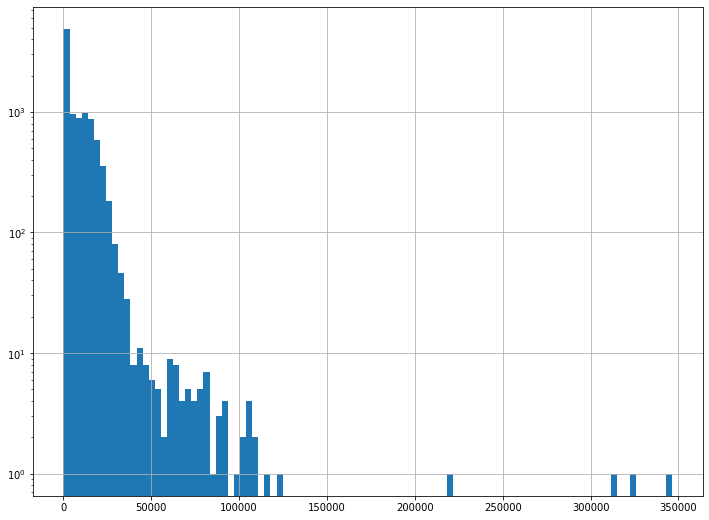

In [87]:
fig, ax = plt.subplots(figsize=(12, 9))
aadt_estimates['AADT Estimate'].hist(ax=ax, bins=100, log=True)

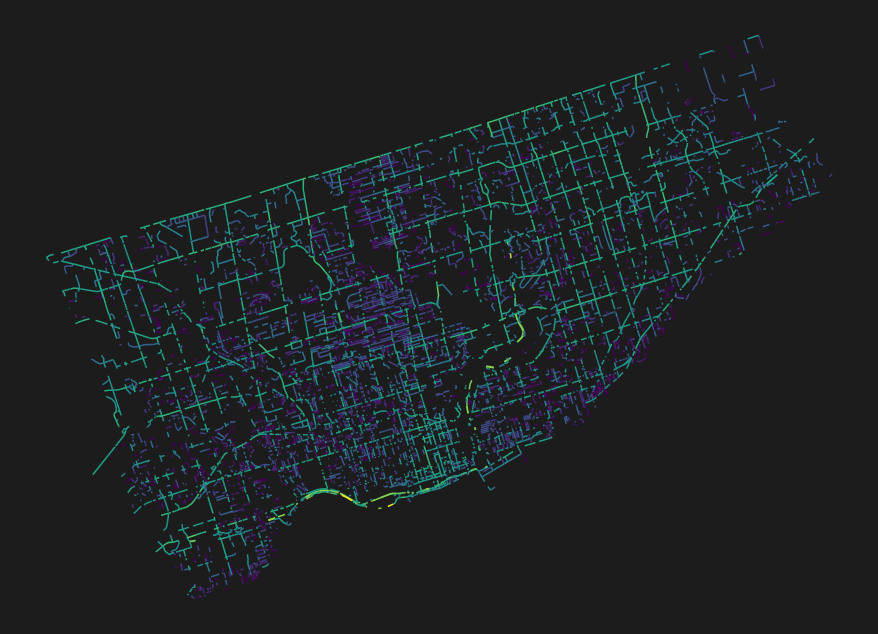

In [88]:
fig = plt.figure(figsize=(12, 9))
fig.patch.set_facecolor('#1c1c1c')
ax = fig.add_axes([0., 0., 1., 1.])
ax.axis('off')
# Not absolute minimum, for more color dynamics.
min_aadt = aadt_estimates['AADT Estimate'].quantile(0.05)
max_aadt = aadt_estimates['AADT Estimate'].max()
aadt_estimates.to_crs(epsg=3857).plot(column='AADT Estimate', ax=ax, cmap='viridis',
                                      norm=colors.LogNorm(), vmin=min_aadt, vmax=max_aadt)

In [89]:
aadt_estimates.head()

,centreline_id,geom,lon,lat,Centreline ID,AADT Estimate
0,7641209.0,"(LINESTRING (-79.541019808 43.590922594, -79.5...",-79.541205,43.591319,7641209,311.950620
1,5729401.0,"(LINESTRING (-79.53738138200001 43.588542623, ...",-79.537924,43.588278,5729401,559.585540
2,914899.0,"(LINESTRING (-79.534668083 43.588403687, -79.5...",-79.534845,43.588736,914899,651.486266
3,7296113.0,"(LINESTRING (-79.535310271 43.589809561, -79.5...",-79.535667,43.590619,7296113,482.734633
4,914841.0,"(LINESTRING (-79.538416068 43.590866629, -79.5...",-79.538909,43.591983,914841,310.806079


In [106]:
import plotly
from plotly import graph_objs as go
from plotly import offline as ploff
from matplotlib import colors as mpl_colors
from matplotlib import cm as mpl_cm

# Online plotting doesn't work because this chart is too big :(
# import chart_studio
# chart_studio.tools.set_credentials_file(
#     username=PLOTLY_USER,
#     api_key=PLOTLY_KEY)
# chart_studio.tools.set_config_file(
#     world_readable=False,
#     sharing='secret')

# import chart_studio.plotly as plon

ploff.init_notebook_mode(connected=True)
plas_cmap = mpl_cm.get_cmap('viridis')

# Get captions for interactive plot
text = []
for i, row in aadt_estimates.iterrows():
    text.append(r"Centreline ID: {id:d}<br>AADT: {aadt:0.3f}"
                .format(id=row['Centreline ID'], aadt=row['AADT Estimate']))    
aadt_estimates['text'] = text

aadt_estimates['scaled_estimate'] = np.log10(aadt_estimates['AADT Estimate'])
aadt_estimates['scaled_estimate'] -= aadt_estimates['scaled_estimate'].quantile(0.05)
aadt_estimates.loc[aadt_estimates['scaled_estimate'] < 0, 'scaled_estimate'] = 0.
aadt_estimates['scaled_estimate'] /= aadt_estimates['scaled_estimate'].max()

data = [
    go.Scattermapbox(
        lat=aadt_estimates['lat'].values,
        lon=aadt_estimates['lon'].values,
        mode='markers',
        marker=dict(
            symbol='circle',
            opacity=1.0,
            size=5.,
            color=[mpl_colors.rgb2hex(plas_cmap(x)[:3])
                   for x in aadt_estimates['scaled_estimate'].values],
        ),
        text=aadt_estimates['text'],
        name='',
    ),
]

layout = go.Layout(
    autosize=True,
    height=600,
    mapbox=dict(
        accesstoken=MAPBOX_TOKEN,
        bearing=0,
        center=dict(lat=43.6932, lon=-79.3632),
        pitch=0,
        zoom=10,
        style='mapbox://styles/czhubditto/ck30d5fuu0vvr1cnvvwv82oqr'
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    showlegend=False,
)

fig = dict(data=data, layout=layout)
ploff.iplot(fig)
# Online plotting doesn't work because this chart is too big :(
#plon.iplot(fig)

# Arman's Validation Method

In [91]:
# Add annual AADT to ts_mse so we can do a weighted average once we've grouped
# by PTC-PTC pairs.

for tc in rdr.ptcs.values():
    tc.tc_mse = pd.merge(tc.tc_mse, tc.data['AADT'],
                         how='left', left_on='Year', right_index=True)    

In [92]:
# def get_aadt_estimates_ptc(rdr, want_year):

want_year = 2011

ptc_count_id = []
ptc_ptc_id_minmse = []
ptc_dij_minmse = []
ptc_closest_year = []
ptc_aadt_est = []
ptc_aadt_actual = []

for tc in rdr.ptcs.values():   
    # Calculate pointwise square error between STTC and neighbouring PTCs,
    # ignoring year.
    tc.tc_mse['Square Deviation'] = (
        tc.tc_mse['MF_STTC'] - tc.tc_mse['MF_PTC'])**2

    # Determine minimum MSE between STTC and each PTC.
    dijs = (tc.tc_mse
            .groupby('PTC ID')[['Square Deviation',
                                'PTC Day-to-AADT Ratio']]
            .mean())
    ptcid_mmse = dijs['Square Deviation'].idxmin()
    dij_mmseptc = dijs.at[ptcid_mmse, 'PTC Day-to-AADT Ratio']

    # Determine average daily count for most recent year to wanted year.
    sttc_years = tc.data['AADT'].index.values
    closest_year = sttc_years[np.abs(want_year - sttc_years).argmin()]
    sttc_daily_count_cyavg = tc.data['Daily Count'].loc[closest_year]['Daily Count'].mean()

    aadt_estimate = (
        sttc_daily_count_cyavg * dij_mmseptc *
        tc.growth_factor**(want_year - closest_year))
    
    aadt_actual = tc.tc_mse.groupby('PTC ID')['AADT'].mean()[ptcid_mmse]

    # Add to lists.
    ptc_count_id.append(tc.count_id)
    ptc_ptc_id_minmse.append(ptcid_mmse)
    ptc_dij_minmse.append(dij_mmseptc)
    ptc_closest_year.append(closest_year)
    ptc_aadt_est.append(aadt_estimate)
    ptc_aadt_actual.append(aadt_actual)

ptc_validation_aadt = pd.DataFrame({
    'Count ID': ptc_count_id,
    'PTC ID': ptc_ptc_id_minmse,
    'D_ij': ptc_dij_minmse,
    'Closest Year': ptc_closest_year,
    'AADT Estimate': ptc_aadt_est,
    'AADT Actual': ptc_aadt_actual})

#     return sttc_aadt, ptc_aadt

(0, 100000)

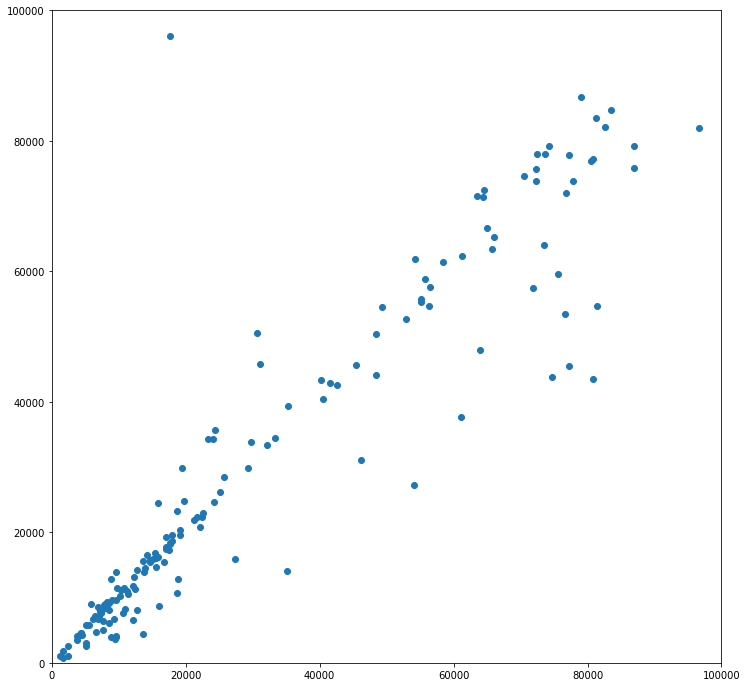

In [93]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(ptc_validation_aadt['AADT Actual'], ptc_validation_aadt['AADT Estimate'],
        marker='o', ls='None')
ax.set_xlim([0, 100000])
ax.set_ylim([0, 100000])

In [94]:
import sklearn.metrics as sklm

In [95]:
sklm.mean_absolute_error(ptc_validation_aadt['AADT Estimate'], ptc_validation_aadt['AADT Actual'])

5774.832038949777

In [96]:
# MAPE
np.mean(
    np.abs(ptc_validation_aadt['AADT Actual'] - ptc_validation_aadt['AADT Estimate']) /
    ptc_validation_aadt['AADT Actual'])

0.24648518145427775

Here, `'AADT Actual'` is the value Arman uses for his ground truth, and our MAPE is quite different from it.  Let's have a better look in the next notebook.